# Copyright Netherlands eScience Center <br>
** Function     : Clustering the patterns of climate fields from reanalyses ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.12.17 ** <br>
** Last Update  : 2019.01.09 ** <br>
Description     : The script aims to implement machine learning to cluster the different patterns given by the variable fields from reanalyses. Some fields are organized as patterns by the climate system (such as SLP, z500). Point-wise analysis then is not as powerful as the clustering methods so as to decrypt the data. Here we will use K-mean clustering to work on the SLP fields in the polar circle.<br>

Return Values   : png <br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib <br>
variables       : SLP <br>
Caveat          : Due to the nature of clustering methods used here, we have to do multiple tests to make sure that the results we obtained are not due to the "unlucky" initialization.<br>

In [1]:
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from scipy import stats
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# constants
constant = {'g' : 9.80616,          # gravititional acceleration [m / s2]
            'R' : 6371009,          # radius of the earth [m]
            'cp': 1004.64,          # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,          # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,        # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,        # gas constant for water vapour [J/(kg*K)]
            'omega' : 7.2921*1E-5,  # Roration rate of the earth [rad/s]
            'rho_air' : 1.225,      # Surface air density [kg/m3]
            'Cd' : 1.56,            # Drag coefficient of 10m wind at 15 Celsius - from Stuart Smith 1988
            }

In [16]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    # AMET
    datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
    # fields
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision/patterns/Filter'
    #####################################################################################
    print ('****************************************************************************')
    print ('********************    latitude index of insteret     *********************')
    print ('****************************************************************************')
    # 60N
    lat_ERAI_60 = 40
    lat_MERRA2_60 = 80 # after a first cut-off to 20N-90N
    lat_JRA55_60 = 53
    print ('*********************** extract variables *************************')
    # AMET
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI, 
                                             'model_daily_075_1979_2016_E_zonal_int.nc'))
    # fields
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    # from 20N - 90N
    # ! attention MERRA2 goes from lower lat to higher lat
    AMET_ERAI = dataset_ERAI_AMET.variables['E'][:,:,lat_ERAI_60]/1000 # from Tera Watt to Peta Watt 
    # 3D fields [time, lat, lon] from 20N - 90N
    SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:,:95,:] #Pa
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:95,:]
    # others
    year_ERAI = dataset_ERAI_AMET.variables['year'][:]             # from 1979 to 2016
    latitude_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    latitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:95]
    longitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI_fields / 360)
    for i in np.arange(len(latitude_ERAI_fields)):
        # change the unit to terawatt
        SLP_ERAI_weight[:,:,:,i] = SLP_ERAI[:,:,i]* dx[i] / dx[-1]

****************************************************************************
********************    latitude index of insteret     *********************
****************************************************************************
*********************** extract variables *************************


In [5]:
    print (latitude_ERAI_fields[:lat_ERAI_60+1])

[90.   89.25 88.5  87.75 87.   86.25 85.5  84.75 84.   83.25 82.5  81.75
 81.   80.25 79.5  78.75 78.   77.25 76.5  75.75 75.   74.25 73.5  72.75
 72.   71.25 70.5  69.75 69.   68.25 67.5  66.75 66.   65.25 64.5  63.75
 63.   62.25 61.5  60.75 60.  ]


In [6]:
    print ('======================   data allocation   ======================')
    # we need to get the time series of SLP for the clustering
    # reshape the input time series
    # we apply the Fortran like index ordering
    t_era, y_era, x_era = SLP_ERAI.shape
    SLP_ERAI_series_2D = np.reshape(SLP_ERAI,[t_era, y_era*x_era], order='F')

======================   data allocation   ======================


In [7]:
    print ('======================   K-mean clustering   ======================')
    ############ full set-up of K-mean ############
    # see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    #class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10,
    #                             max_iter=300, tol=0.0001, precompute_distances=’auto’,
    #                             verbose=0, random_state=None, copy_x=True, n_jobs=None,
    #                             algorithm=’auto’)
    # n_init : int, default: 10
    # Number of time the k-means algorithm will be run with different centroid seeds.
    # The final results will be the best output of n_init consecutive runs in terms of inertia.
    ###############################################
    kmeans = KMeans(n_clusters=4)
    model = kmeans.fit(SLP_ERAI_series_2D)
    clust_labels = model.predict(SLP_ERAI_series_2D)
    print("ERA-Interim\n", model)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [8]:
    centers = model.cluster_centers_
    n_era, nn_era = centers.shape
    # shape back to the spatial arrangement
    centers_spatial = np.reshape(centers,[n_era, y_era, x_era], order='F')

======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


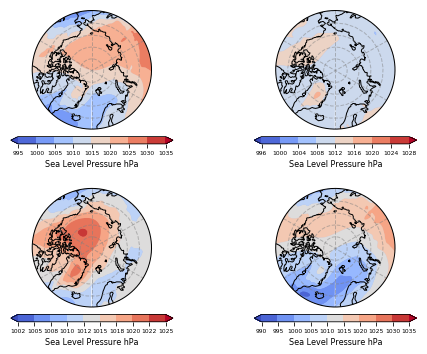

In [9]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_Kmean.png'), dpi=300)
    plt.close(fig)

In [71]:
    print ('======================   check the heat map of K-mean   ======================')
    print (clust_labels)
    print (len(clust_labels[clust_labels==3]))

======================   check the heat map of K-mean   ======================
[2 2 2 2 2 1 3 1 0 1 0 3 2 0 2 2 2 1 1 3 3 1 2 0 3 0 2 1 1 1 3 3 1 2 0 1 2
 0 0 1 2 1 3 3 3 1 0 0 0 0 0 2 2 3 3 3 1 3 1 0 0 0 2 2 1 1 1 3 1 0 0 0 2 2
 1 2 2 1 1 1 1 3 2 2 0 2 3 1 2 3 1 1 1 3 0 0 0 2 2 2 1 1 1 1 3 3 0 2 0 2 2
 2 2 3 1 3 3 3 0 3 3 3 0 2 1 3 3 3 3 3 0 0 0 0 3 3 3 1 1 1 1 3 1 0 0 0 2 1
 1 1 3 3 0 1 0 3 0 0 0 2 3 1 3 3 1 1 0 3 3 0 0 2 2 1 1 1 1 1 3 2 2 2 0 2 1
 3 3 3 3 3 3 0 0 0 0 2 2 1 1 3 1 1 1 1 0 3 1 2 1 1 3 3 2 0 0 2 0 0 0 1 2 1
 1 3 3 1 1 0 2 0 2 2 1 1 1 3 1 0 2 0 0 0 2 2 2 3 1 1 3 0 0 0 0 0 2 2 1 3 1
 1 3 0 2 2 0 2 2 1 1 1 3 3 1 0 3 0 0 0 1 1 1 3 3 1 3 1 2 0 0 0 0 1 1 1 3 3
 3 1 0 3 2 2 2 2 2 1 3 1 3 1 1 0 0 0 2 2 2 1 3 3 3 3 0 0 0 1 2 2 1 3 3 3 3
 1 0 3 0 2 0 1 1 1 1 3 1 3 2 0 0 0 2 2 2 1 1 3 1 3 0 0 0 2 2 1 1 1 1 1 3 2
 0 2 0 2 2 2 2 1 3 1 1 1 1 2 0 0 3 0 2 1 1 1 3 3 0 0 0 0 0 2 1 1 3 3 3 2 0
 2 2 2 2 2 1 3 1 3 1 3 3 0 0 0 0 3 1 1 1 1 3 2 0 0 0 0 0 1 1 1 1 1 3 3 0 0
 0 0 0 2 2 3 1 3 3 1 

The benchmark of the implementation of K-mean is listed above. Now we will apply this method to the seasonal anomalies of SLP from each reanalyses.<br>

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [11]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [12]:
    print ('================   K-mean clustering of SLP anomalies in winter  ================')
    # get winter time series
    # ERA-Interim
    SLP_ERAI_season_series = meta.statistics.operator.seasons(SLP_ERAI[:,:lat_ERAI_60+1,:],
                                                              span='DJF', Dim_month=False)    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    #stat_OMET_ORAS4.detrend()
    #stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    # flatten the time series
    t_era, y_era, x_era = stat_SLP_ERAI._anomaly.shape
    stat_SLP_ERAI_anomaly_2D = np.reshape(stat_SLP_ERAI._anomaly,
                                          [t_era, y_era*x_era], order='F')

================   K-mean clustering of SLP anomalies in winter  ================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


In [13]:
    print ('======================   K-mean clustering   ======================')
    kmeans_era = KMeans(n_clusters=4, n_init=50)
    model_era = kmeans_era.fit(stat_SLP_ERAI_anomaly_2D)
    clust_labels_era = model_era.predict(stat_SLP_ERAI_anomaly_2D)
    print("ERA-Interim\n", model_era)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [14]:
    print ('===================   check the centers from K-mean clustering   ===================')
    centers_era = model_era.cluster_centers_
    n_era, nn_era = centers_era.shape
    # shape back to the spatial arrangement
    centers_spatial_era = np.reshape(centers_era,[n_era, y_era, x_era], order='F')

===================   check the centers from K-mean clustering   ===================


======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


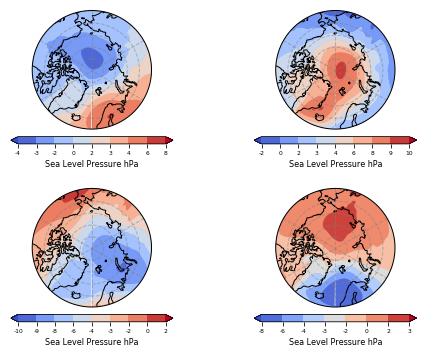

In [17]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields[:lat_ERAI_60+1], standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean.png'), dpi=300)
    plt.close(fig)

======================   plot the centers of K-mean   ======================
======================  Atlantic ocean only zoom in   ======================
======================    SLP original time series    ======================


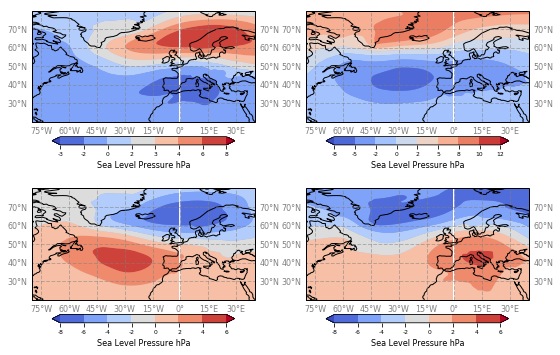

In [46]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================  Atlantic ocean only zoom in   ======================')
    print ('======================    SLP original time series    ======================')
    print ('======================         only for a check       ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(9,6),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-80,40,20,80],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'color': 'gray'}
        gl.ylabel_style = {'size': 8, 'color': 'gray'}
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.1, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean_atlantic.png'), dpi=300)
    plt.close(fig)

In [18]:
    print ('======================   check the heat map of K-mean   ======================')
    print ('ERA-Interim')
    print (clust_labels_era)
    print ('mode 1', len(clust_labels_era[clust_labels_era==0])/len(clust_labels_era))
    print ('mode 2', len(clust_labels_era[clust_labels_era==1])/len(clust_labels_era))
    print ('mode 3', len(clust_labels_era[clust_labels_era==2])/len(clust_labels_era))
    print ('mode 4', len(clust_labels_era[clust_labels_era==3])/len(clust_labels_era))
    #print ('mode 5', len(clust_labels_era[clust_labels_era==4])/len(clust_labels_era))
    #print ('mode 6', len(clust_labels_era[clust_labels_era==5])/len(clust_labels_era))
    #print ('mode 7', len(clust_labels_era[clust_labels_era==6])/len(clust_labels_era))
    #print ('mode 8', len(clust_labels_era[clust_labels_era==7])/len(clust_labels_era))

======================   check the heat map of K-mean   ======================
ERA-Interim
[1 1 0 1 0 3 0 0 0 0 2 3 3 0 3 3 0 0 1 1 1 3 0 0 0 1 1 2 1 2 2 2 2 3 2 3 3
 0 2 2 3 2 2 2 3 1 0 0 3 3 1 0 0 1 0 2 2 1 3 3 0 3 3 3 3 1 1 1 0 2 3 0 0 0
 0 1 1 3 3 0 0 0 0 2 2 1 3 0 3 0 0 1 1 0 1 1 0 0 3 0 0 1 1 1 2 0 3 3 3 2 3
 0 3 2]
mode 1 0.3333333333333333
mode 2 0.22807017543859648
mode 3 0.17543859649122806
mode 4 0.2631578947368421


==================   projection of data back to the cluster   ==================
==================   the eigen values are euclidean distance  ==================
================== short distance means close to the pattern  ==================


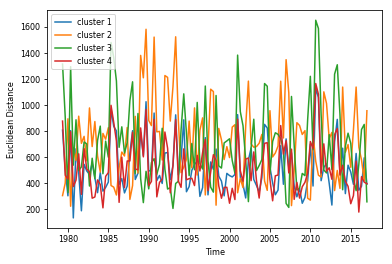

In [19]:
    print ('==================   projection of data back to the cluster   ==================')
    print ('==================   the eigen values are euclidean distance  ==================')
    print ('================== short distance means close to the pattern  ==================')
    SLP_ERAI_Kmean_proj = np.zeros((4,len(clust_labels_era)), dtype=float)
    for i in np.arange(4):
        mode = centers_spatial_era[i,:,:]
        mode_3D = np.repeat(mode[np.newaxis,:,:],len(clust_labels_era),0)
        SLP_ERAI_Kmean_proj[i,:] = np.mean(np.mean(np.abs(mode_3D-stat_SLP_ERAI._anomaly),2),1)

    index_full = np.arange(1,445,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,115,1)        
        
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI)*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean_eigen.png'),dpi=300)
    plt.close(fig)

==================   filter the data at large time scale   ==================


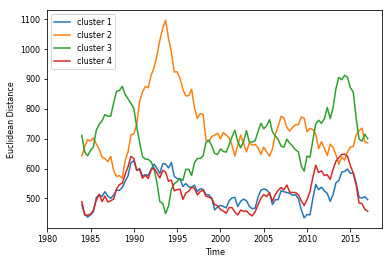

In [23]:
    print ('==================   filter the data at large time scale   ==================')
    _, l = SLP_ERAI_Kmean_proj.shape
    SLP_ERAI_Kmean_proj_filter = np.zeros((4,l-15+1), dtype=float)
    for i in np.arange(4):
        stat_SLP_ERAI_Kmean = meta.statistics.operator(SLP_ERAI_Kmean_proj[i,:])
        stat_SLP_ERAI_Kmean.lowpass(window=15, obj='original')
        SLP_ERAI_Kmean_proj_filter[i,:] = stat_SLP_ERAI_Kmean._lowpass

    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season[14:],SLP_ERAI_Kmean_proj_filter[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI[:])*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean_eigen_interannual.png'),dpi=300)
    plt.close(fig)

In [24]:
    print ('==================  regression of AMET on the SLP projection  ==================')
    AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                               span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    #stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='anomaly')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_Kmean_proj_filter[i,:],
                                                         stat_AMET_ERAI._lowpass)
        print ('ERA-Interim cluster {}'.format(i+1))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)    

==================  regression of AMET on the SLP projection  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
ERA-Interim cluster 1
regression coefficient (Pa/PW)
0.0005378362928004217
correlation coefficient
0.221962865990755
t-test
0.026453648440687934
ERA-Interim cluster 2
regression coefficient (Pa/PW)
0.00017526847620896735
correlation coefficient
0.1672885155760601
t-test
0.09619275099010616
ERA-Interim cluster 3
regression coefficient (Pa/PW)
-2.382032055583351e-06
correlation coefficient
-0.0020416778072759744
t-test
0.983915651738895
ERA-Interim cluster 4
regression coefficient (Pa/PW)
0.0005560608536482311
correlation coefficient
0.2690346476564855
t-test
0.006797274923528618


Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [25]:
    print ('================   K-mean clustering of SLP anomalies in summer  ================')
    # get winter time series
    # ERA-Interim
    SLP_ERAI_season_series = meta.statistics.operator.seasons(SLP_ERAI[:,:lat_ERAI_60+1,:],
                                                              span='JJA', Dim_month=False)    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    # flatten the time series
    t_era, y_era, x_era = stat_SLP_ERAI._anomaly.shape
    stat_SLP_ERAI_anomaly_2D = np.reshape(stat_SLP_ERAI._anomaly,
                                          [t_era, y_era*x_era], order='F')

================   K-mean clustering of SLP anomalies in summer  ================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


In [26]:
    print ('======================   K-mean clustering   ======================')
    kmeans_era = KMeans(n_clusters=4, n_init=50)
    model_era = kmeans_era.fit(stat_SLP_ERAI_anomaly_2D)
    clust_labels_era = model_era.predict(stat_SLP_ERAI_anomaly_2D)
    print("ERA-Interim\n", model_era)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [27]:
    print ('===================   check the centers from K-mean clustering   ===================')
    centers_era = model_era.cluster_centers_
    n_era, nn_era = centers_era.shape
    # shape back to the spatial arrangement
    centers_spatial_era = np.reshape(centers_era,[n_era, y_era, x_era], order='F')

===================   check the centers from K-mean clustering   ===================


======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


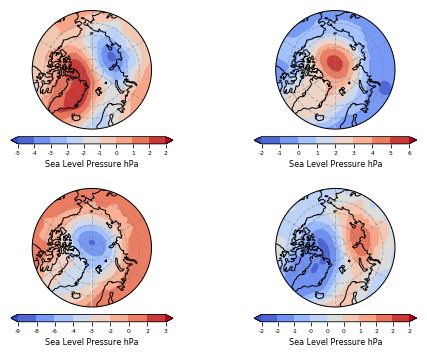

In [28]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields[:lat_ERAI_60+1], standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean.png'), dpi=300)
    plt.close(fig)

In [29]:
    print ('======================   check the hit map of K-mean   ======================')
    print ('ERA-Interim')
    print (clust_labels_era)
    print ('mode 1', len(clust_labels_era[clust_labels_era==0])/len(clust_labels_era))
    print ('mode 2', len(clust_labels_era[clust_labels_era==1])/len(clust_labels_era))
    print ('mode 3', len(clust_labels_era[clust_labels_era==2])/len(clust_labels_era))
    print ('mode 4', len(clust_labels_era[clust_labels_era==3])/len(clust_labels_era))
    #print ('mode 5', len(clust_labels_era[clust_labels_era==4])/len(clust_labels_era))
    #print ('mode 6', len(clust_labels_era[clust_labels_era==5])/len(clust_labels_era))
    #print ('mode 7', len(clust_labels_era[clust_labels_era==6])/len(clust_labels_era))
    #print ('mode 8', len(clust_labels_era[clust_labels_era==7])/len(clust_labels_era))

======================   check the hit map of K-mean   ======================
ERA-Interim
[3 3 1 0 1 3 1 2 3 1 3 3 2 3 2 3 3 3 3 1 1 2 1 3 1 3 1 3 0 3 2 2 0 3 3 1 3
 3 2 3 2 3 1 0 1 2 3 2 3 1 2 3 2 3 1 3 2 1 1 3 2 3 1 0 3 1 3 0 3 2 0 1 3 2
 3 1 3 1 1 3 0 2 3 3 1 0 0 0 1 1 1 1 0 1 2 0 1 0 1 1 0 0 2 3 3 1 1 0 0 1 1
 2 0 2]
mode 1 0.16666666666666666
mode 2 0.30701754385964913
mode 3 0.18421052631578946
mode 4 0.34210526315789475


==================   projection of data back to the cluster   ==================
==================   the eigen values are euclidean distance  ==================
================== short distance means close to the pattern  ==================


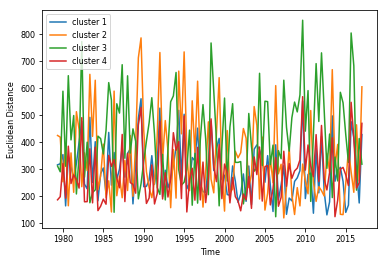

In [30]:
    print ('==================   projection of data back to the cluster   ==================')
    print ('==================   the eigen values are euclidean distance  ==================')
    print ('================== short distance means close to the pattern  ==================')
    SLP_ERAI_Kmean_proj = np.zeros((4,len(clust_labels_era)), dtype=float)
    for i in np.arange(4):
        mode = centers_spatial_era[i,:,:]
        mode_3D = np.repeat(mode[np.newaxis,:,:],len(clust_labels_era),0)
        SLP_ERAI_Kmean_proj[i,:] = np.mean(np.mean(np.abs(mode_3D-stat_SLP_ERAI._anomaly),2),1)

    index_full = np.arange(1,445,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,115,1)        
        
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI)*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean_eigen.png'),dpi=300)
    plt.close(fig)

==================   filter the data at large time scale   ==================


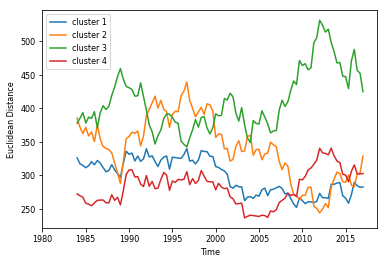

In [31]:
    print ('==================   filter the data at large time scale   ==================')
    _, l = SLP_ERAI_Kmean_proj.shape
    SLP_ERAI_Kmean_proj_filter = np.zeros((4,l-15+1), dtype=float)
    for i in np.arange(4):
        stat_SLP_ERAI_Kmean = meta.statistics.operator(SLP_ERAI_Kmean_proj[i,:])
        stat_SLP_ERAI_Kmean.lowpass(window=15, obj='original')
        SLP_ERAI_Kmean_proj_filter[i,:] = stat_SLP_ERAI_Kmean._lowpass

    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season[14:],SLP_ERAI_Kmean_proj_filter[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI[:])*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean_eigen_interannual.png'),dpi=300)
    plt.close(fig)

In [32]:
    print ('==================  pick-up AMET w.r.t. clustering  ==================')
    AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                               span='JJA', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    #stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='anomaly')
    
    print ('==================  regression of AMET on the SLP projection  ==================')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_Kmean_proj_filter[i,:],
                                                         stat_AMET_ERAI._lowpass)
        print ('ERA-Interim cluster {}'.format(i+1))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)    

==================  pick-up AMET w.r.t. clustering  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
==================  regression of AMET on the SLP projection  ==================
ERA-Interim cluster 1
regression coefficient (Pa/PW)
-0.0032683583910541785
correlation coefficient
-0.6479182468858897
t-test
3.1861543418817684e-13
ERA-Interim cluster 2
regression coefficient (Pa/PW)
-0.0011959502232508341
correlation coefficient
-0.43102807711826513
t-test
7.578745612836482e-06
ERA-Interim cluster 3
regression coefficient (Pa/PW)
0.0009776161570650276
correlation coefficient
0.33110068282551763
t-test
0.0007659514872853777
ERA-Interim cluster 4
regression coefficient (Pa/PW)
0.0016912651276822035
correlation coefficient
0.3291026814836449
t-test
0.0008278986926368763
